In [1]:
import tweepy
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p

In [2]:
#Twitter credentials for the app
consumer_key = 'xxxxx'
consumer_secret = 'xxxx'
access_key= 'xxxx'
access_secret = 'xxxx'

In [3]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [4]:
#declare file paths as follows for three files
apple_tweets = "Apple-Twitter-Sentiment-DFE.csv"

In [5]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
'favorite_count', 'retweet_count', 'original_author',   'possibly_sensitive', 'hashtags',
'user_mentions', 'place', 'place_coord_boundaries']

In [6]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [7]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [8]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [9]:
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [10]:
df = pd.read_csv('Apple-Twitter-Sentiment-DFE.csv', encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [11]:
df.shape

(3886, 12)

In [12]:
df['text'][0]

'#AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx'

In [13]:
clean_text = [p.clean(x) for x in df['text']]
clean_text[:20]

[':The best Steve Jobs emails ever...',
 ': Why AAPL Stock Had a Mini-Flash Crash Today $AAPL ://',
 'My cat only chews cords. Such an .',
 "I agree with that the should own not trade , it's extended so today's pullback is good to see",
 'Nobody expects the Spanish Inquisition',
 ':5 Rocket Stocks to Buy for December Gains: Apple and More...',
 'Top all . Damn right!',
 "CNBCTV: 's margins better than expected?",
 'Apple Inc. Flash Crash: What You Need to Know',
 ":This Presentation Shows What Makes The World's Biggest Tech Companies ...",
 'WTF MY BATTERY WAS % ONE SECOND AGO AND NOW IS % WTF IS THIS',
 'Apple Watch Tops Search Engine List of Best Wearable Tech',
 'The Best-Designed In the World, According to :',
 ": Bought my at the store..pretty good logo match . can't wait to install it!",
 'Contact sync between Yosemite and iOS8 is seriously screwed up. It used to be much more stable in the past.',
 'Thanks to the non factual dumb Twitter followers stock drops points in one minute

In [14]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

clean_text = preprocess_reviews(clean_text)

In [15]:
stop_words=['in','of','at','a','the']

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in stop_words])
        )
    return removed_stop_words

clean_text = remove_stop_words(clean_text)

In [16]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Alec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

lemmatized_reviews = get_lemmatized_text(clean_text)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np
import scipy

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [20]:
# ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
ngram_vectorizer = CountVectorizer()
ngram_vectorizer.fit(lemmatized_reviews)
X = ngram_vectorizer.transform(lemmatized_reviews)

In [21]:
y = df['sentiment']

In [22]:
# ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(lemmatized_reviews)
X1 = tfidf_vectorizer.transform(lemmatized_reviews)

In [23]:
print(X.shape)
print(X1.shape)
print(y.shape)

(3886, 4794)
(3886, 4794)
(3886,)


LR with count vectorizer

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Instantiate k fold cross-validator 
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# instantiate logistic regression classifier
lr = LogisticRegression(max_iter=1000)

# define hyperparameter grid
p_grid = {"C": list(np.linspace(0.1, 0.9, num=9))}

# instantiate grid search and fit to data
gscv = GridSearchCV(lr, p_grid, cv=kf)
gscv.fit(X, y)

# Get cross-validation data
cv_df = pd.DataFrame(gscv.cv_results_)

In [25]:
cv_df[["param_C", "mean_test_score"]]

,param_C,mean_test_score
0,0.1,0.728513
1,0.2,0.735719
2,0.3,0.737778
3,0.4,0.737521
4,0.5,0.735976
5,0.6,0.737521
6,0.7,0.737777
7,0.8,0.737521
8,0.9,0.735719


SVM with count vectorizer

In [26]:
# k fold cross-validator already instantiated
# instantiate linear SVM classifier
svc = LinearSVC()

# hyperparameter grid already defined

# instantiate grid search and fit to data
gscv1 = GridSearchCV(svc, p_grid, cv=kf)
gscv1.fit(X, y)

# Get cross-validation data
cv_df1 = pd.DataFrame(gscv1.cv_results_)

In [27]:
cv_df1[["param_C", "mean_test_score"]]

,param_C,mean_test_score
0,0.1,0.736748
1,0.2,0.729803
2,0.3,0.725941
3,0.4,0.725170
4,0.5,0.724398
5,0.6,0.724140
6,0.7,0.724140
7,0.8,0.722082
8,0.9,0.720537


LR with tfidf vectorizer

In [28]:
# k fold cross-validator already instantiated
# logistic regression classifier already instantiated

# hyperparameter grid already defined

# instantiate grid search CV
gscv2 = GridSearchCV(lr, p_grid, cv=kf)
gscv2.fit(X1, y)

# Get cross-validation data
cv_df2 = pd.DataFrame(gscv2.cv_results_)

In [29]:
cv_df2[["param_C", "mean_test_score"]]

,param_C,mean_test_score
0,0.1,0.675504
1,0.2,0.698150
2,0.3,0.710242
3,0.4,0.714874
4,0.5,0.719506
5,0.6,0.721308
6,0.7,0.724653
7,0.8,0.726453
8,0.9,0.727226


SVM with tfidf vectorizer

In [30]:
# k fold cross-validator already instantiated
# SVM classifier already instantiated

# hyperparameter grid already defined

# instantiate grid search CV
gscv3 = GridSearchCV(svc, p_grid, cv=kf)
gscv3.fit(X1, y)

# Get cross-validation data
cv_df3 = pd.DataFrame(gscv3.cv_results_)

In [31]:
cv_df3[["param_C", "mean_test_score"]]

,param_C,mean_test_score
0,0.1,0.723624
1,0.2,0.731343
2,0.3,0.733916
3,0.4,0.732373
4,0.5,0.730057
5,0.6,0.730315
6,0.7,0.729801
7,0.8,0.730315
8,0.9,0.730058


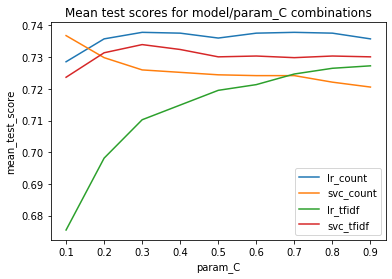

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df_dict = {"lr_count": cv_df, 
           "svc_count": cv_df1, 
           "lr_tfidf": cv_df2, 
           "svc_tfidf": cv_df3}
for key, val in df_dict.items():
    sns.lineplot(x="param_C", y="mean_test_score", data=val, label=key)
plt.title("Mean test scores for model/param_C combinations")
plt.legend();

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, random_state=42)
lr_optimized = LogisticRegression(C=0.3, max_iter=1000)
lr_optimized.fit(X_train, y_train)
y_pred = lr_optimized.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.63      0.70       401
           3       0.73      0.93      0.81       710
           5       0.70      0.26      0.38       151
not_relevant       0.00      0.00      0.00        21

    accuracy                           0.74      1283
   macro avg       0.55      0.46      0.48      1283
weighted avg       0.73      0.74      0.72      1283



/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
confusion = confusion_matrix(y_test, y_pred)
#cm = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

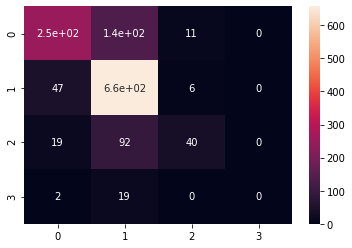

In [39]:
g = sns.heatmap(confusion, annot=True)